In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# SEPP Estimation test bed

An attempt to replicate the appendix of Mohler et al.  Here we setup a simple example of a self-exciting point process.  The background rate is constant in time, and normally distributed in space.  The "triggered" (or "aftershock") events follow an exponential distribution in time, and are normally distributed with a scale much smaller than that of the background events.

We compare using a fixed bandwidth KDE (from the `scipy.stats` package), a nearest neighbour variable bandwidth estimator, and a combination of two nearest neighbour variable bandwidth estimators.  All show edge effects in time for the bandwidth estimation.

The nearest neighbour variable bandwidth estimator used for the triggered events shows poor performance in time, and gives a heavy tail estimation for the space component.  This is an artifact of the KDE used, which is a not a good match for the artificial data.  See the "kernels" notebook for more on this.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp.sepp as sepp
import open_cp.sources.sepp as seppsim
import open_cp
import open_cp.kernels
import scipy.stats
import scipy.integrate

In [3]:
background_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.HomogeneousPoisson(rate=5.71),
    seppsim.GaussianSpaceSampler([0,0], [4.5**2, 4.5**2], 0))
total_rate = 0.2
trigger_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.Exponential(exp_rate=0.1, total_rate=total_rate),
    seppsim.GaussianSpaceSampler([0,0], [0.01**2, 0.1**2], 0))
sampler = seppsim.SelfExcitingPointProcess(background_sampler, trigger_sampler)

## Background events

These are a constant rate marked Poisson process, with the "marks" (the space coordinates) normally distributed.  It is not clear to me why Mohler et al. chose 5.71 as the Poisson rate!

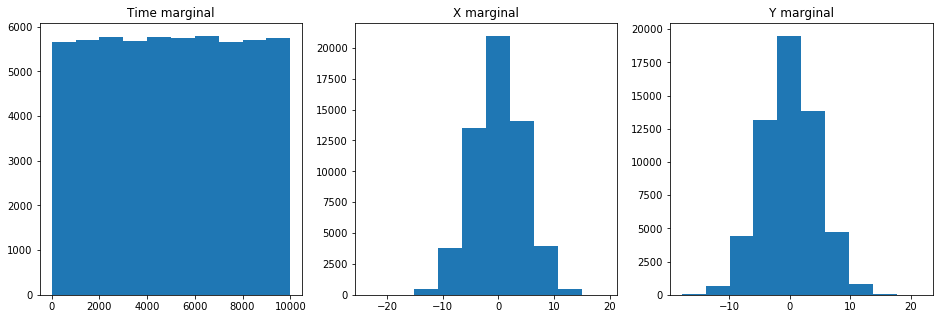

In [4]:
backs = background_sampler.sample(0, 10000)
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i, t in enumerate(["Time", "X", "Y"]):
    ax[i].hist(backs[i])
    ax[i].set_title(t + " marginal")

## Triggered events

I believe there is a **mis-print in the paper** here.  They display the formula

$$ g(t,x,y) = \theta \omega \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
with parameters $\sigma_x=0.01, \sigma_y=0.1, \theta=0.2, \omega^{-1}=10$.  However, in Figure A.2. they show the time marginal (i.e. integrate out $x$ and $y$ which is an exponential decay with value $0.02 = \theta\omega$ at $t=0$.

Thus, I believe that the normalisation of the Gaussian is missing, and we should have
$$ g(t,x,y) = \frac{\theta}{2\pi\sigma_x\sigma_y} \omega \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
The marginals for $x$ and $y$ also agree with this.

In [5]:
trigs = []
for _ in range(50000):
    x = trigger_sampler.sample(0, 100)
    trigs.extend(x.T)
trigs = np.asarray(trigs).T
trigs.shape

(3, 9993)

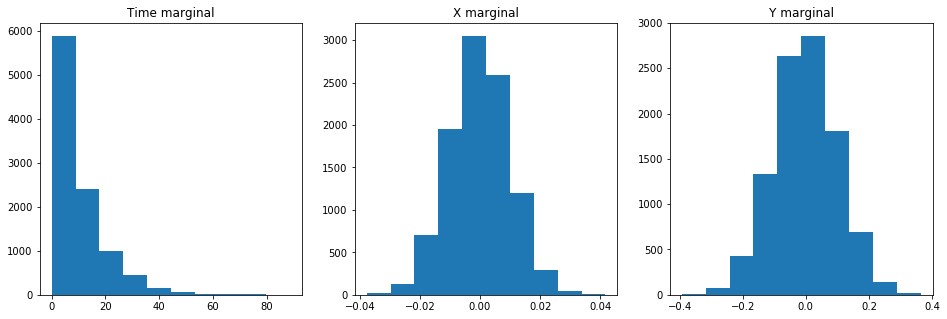

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i, t in enumerate(["Time", "X", "Y"]):
    ax[i].hist(trigs[i])
    ax[i].set_title(t + " marginal")

# Sample from the process

We take a sample from the self-exciting points process, and keep the information on which are initial background events, and which are triggered events (either triggered from the background, or from other triggered events).

In [7]:
time_range = (200, 700)
sample = sampler.sample_with_details(0,time_range[1])
pts = sample.points
pts.shape, sample.backgrounds.shape, sample.trigger_deltas.shape

((3, 4938), (3, 3965), (3, 973))

In Mohler et al. they:

>  In order to have a realization of the point process at steady state, the first and last 2000 points were disregarded in each simulation.

There seems no reason to discard the _last_ $N$ points, because there is no "feedback" mechanism in the process-- only the past can change what happens now.  So there is no edge effect at the end of a simulation.

There is an edge effect at the start, and so it is reasonble to discard the initial data.

In [8]:
cutoff_time = time_range[0]
pts = pts[:, pts[0] >= cutoff_time]
backs = sample.backgrounds[:, sample.backgrounds[0] >= cutoff_time]
trigs_mask = sample.trigger_points[0] >= cutoff_time
trigs = sample.trigger_deltas[:, trigs_mask]
trig_pts = sample.trigger_points[:, trigs_mask]

sample = open_cp.sources.sepp.SelfExcitingPointProcess.Sample(pts, backs,
        trigs, trig_pts)
pts.shape, sample.backgrounds.shape, sample.trigger_deltas.shape

((3, 3553), (3, 2833), (3, 707))

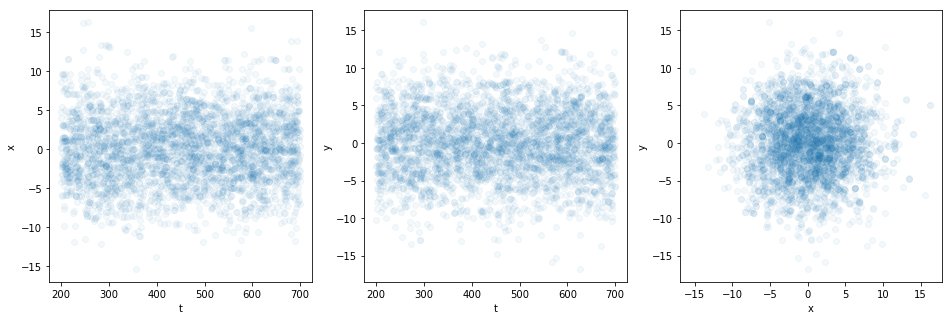

In [9]:
def two_dim_slices(pts, alpha=0.5):
    fig, ax = plt.subplots(ncols=3, figsize=(16,5))
    ax[0].scatter(pts[0], pts[1], alpha=alpha)
    ax[0].set(xlabel="t", ylabel="x")
    ax[1].scatter(pts[0], pts[2], alpha=alpha)
    ax[1].set(xlabel="t", ylabel="y")
    ax[2].scatter(pts[1], pts[2], alpha=alpha)
    ax[2].set(xlabel="x", ylabel="y")
    
two_dim_slices(pts, 0.05)

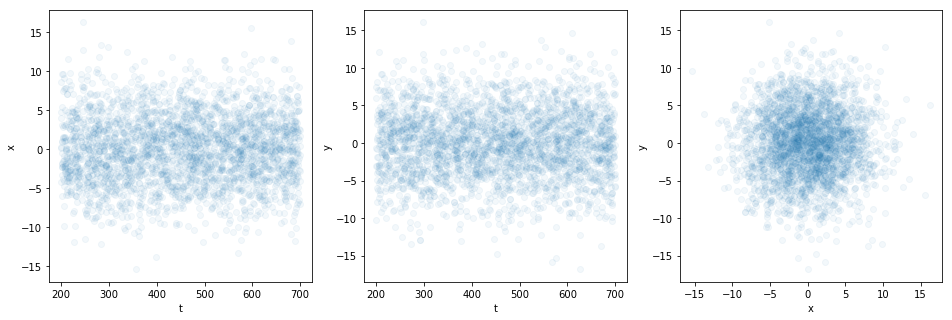

In [10]:
two_dim_slices(sample.backgrounds, 0.05)

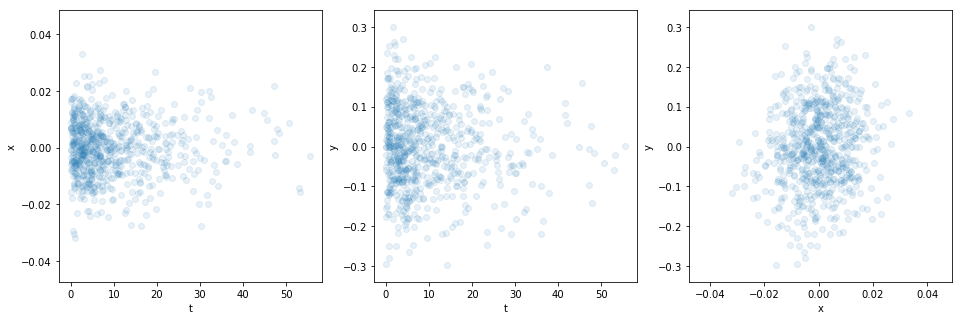

In [11]:
two_dim_slices(sample.trigger_deltas, 0.1)

We will ultimately be doing the following:
    
- Estimating the matrix $p$ which encodes how likely it is that a point is a background event, or is triggered by some previous point.
- Sampling from the resulting probability distributions to classify points as background or triggered
- Applying a kernel density estimation to recover an estimate of the intensity of background events and an intensity of triggered events.

With this in mind, it is useful to have an estimate of what the "real" sample gives us.  Below we use the actual triggered events from our process, project onto each coordinate (which is valid, as for the real kernel, the coordinates are independent) and use the `scipy` KDE to get a visualisation of the resulting kernel.  (We could also have used a histogram.)

It is worth reminding ourselves that the general purpose KDE we use here will always cope badly with the time data, as that is here sampled from an exponential distribution, and there is a discontinuity at $t=0$.

In [12]:
def plot_actual_trig_marginals():
    def actual_t_marginal(t):
        return 0.2 * np.exp(-t/10)/10
    def actual_x_marginal(x):
        return 0.2 * np.exp(-x*x/(2*0.01**2)) / np.sqrt(2*np.pi*0.01**2)
    def actual_y_marginal(y):
        return 0.2 * np.exp(-y*y/(2*0.1**2)) / np.sqrt(2*np.pi*0.1**2)

    fig, ax = plt.subplots(ncols=3, figsize=(16,5))

    tc = np.linspace(0,60,100)
    actual = actual_t_marginal(tc)
    ax[0].plot(tc, actual, color="red", linewidth=1)

    xc = np.linspace(-0.05,0.05,100)
    actual = actual_x_marginal(xc)
    ax[1].plot(xc, actual, color="red", linewidth=1)

    yc = np.linspace(-0.5,0.5,100)
    actual = actual_y_marginal(yc)
    ax[2].plot(yc, actual, color="red", linewidth=1)

    return ax

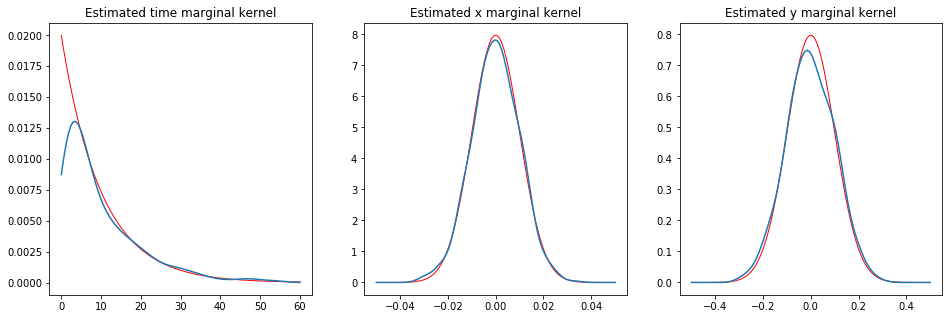

In [13]:
def plot_estimated_trig_kernels(pts, trigs):
    rescale = trigs.shape[-1] / pts.shape[-1]
    ax = plot_actual_trig_marginals()

    trigs_t_kernel = scipy.stats.gaussian_kde(trigs[0])
    x = np.linspace(0, 60, 100)
    ax[0].plot(x, trigs_t_kernel(x) * rescale)
    ax[0].set_title("Estimated time marginal kernel")

    trigs_x_kernel = scipy.stats.gaussian_kde(trigs[1])
    x = np.linspace(-0.05, 0.05, 100)
    ax[1].plot(x, trigs_x_kernel(x) * rescale)
    ax[1].set_title("Estimated x marginal kernel")

    trigs_y_kernel = scipy.stats.gaussian_kde(trigs[2])
    x = np.linspace(-0.5, 0.5, 100)
    ax[2].plot(x, trigs_y_kernel(x) * rescale)
    ax[2].set_title("Estimated y marginal kernel")

plot_estimated_trig_kernels(pts, trigs)

## Using the real distributions

We now construct the "p" matrix using the actual kernels the data was sampled from.  Using this matrix, we then sample background and triggered points.  By visual inspection, the scatter plots look very similar to those above, suggesting that this sampling method works as expected.

In [14]:
def actual_background_kernel(pts):
    norm = 2 * 4.5 * 4.5
    return 5.71 * np.exp(- (pts[1]**2 + pts[2]**2) / norm) / (norm * np.pi)

def actual_trigger_kernel(pts):
    sigma_x = 0.01
    sigma_y = 0.1
    theta = 0.2
    omega = 1 / 10
    return ( theta * omega * np.exp(-omega * pts[0]) *
        np.exp(-pts[1]**2 / (2 * sigma_x**2)) * np.exp(-pts[2]**2 / (2 * sigma_y**2))
        / (2 * np.pi * sigma_x * sigma_y) )

In [15]:
p = sepp.p_matrix(pts, actual_background_kernel, actual_trigger_kernel)
backs, trigs = sepp.sample_points(pts, p)
pts.shape, backs.shape, trigs.shape

((3, 3553), (3, 2873), (3, 680))

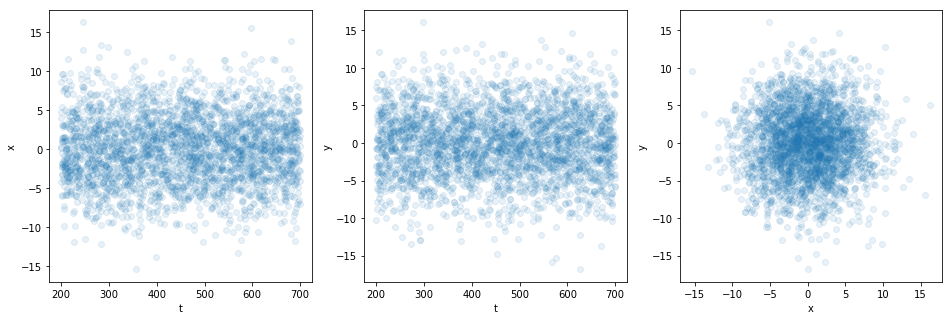

In [16]:
two_dim_slices(backs, alpha=0.1)

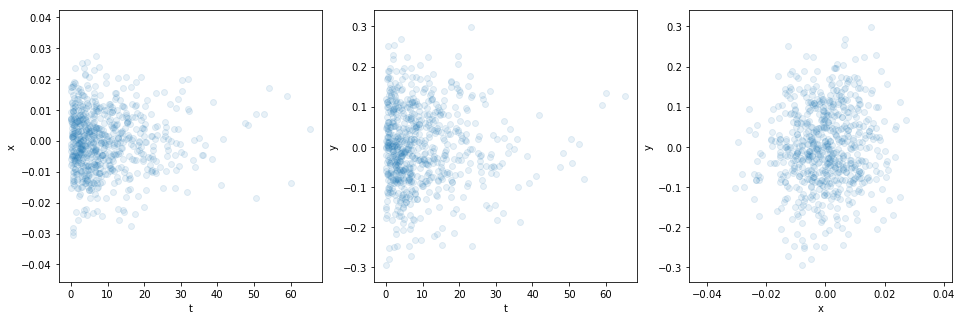

In [17]:
two_dim_slices(trigs, alpha=0.1)

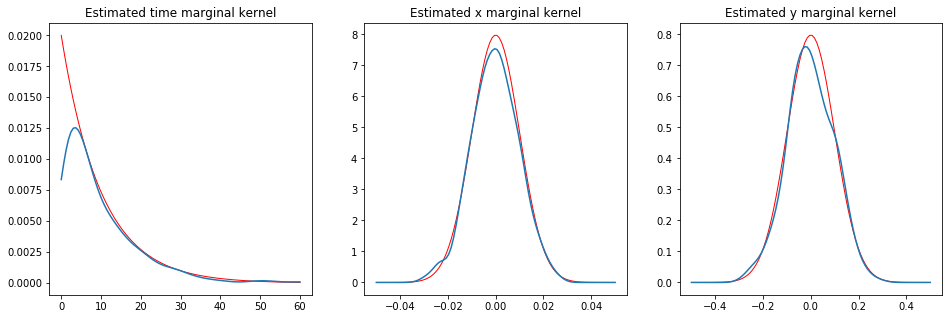

In [18]:
plot_estimated_trig_kernels(pts, trigs)

## Using scipy's Gaussian KDE

Just for comparison, let's start by using an "out of the box" kernel density estimator.  `scipy.stats.gaussian_kde` has a fixed bandwidth which by default is "Scott's Rule".

It's worth noting that while our hand-coded nearest neighbour KDE is slow, so is the scipy implementation (of what is an easier algorithm).  Here "slow" means "slow to evaulate the resulting kernel".

In [19]:
kernel = scipy.stats.gaussian_kde(backs)

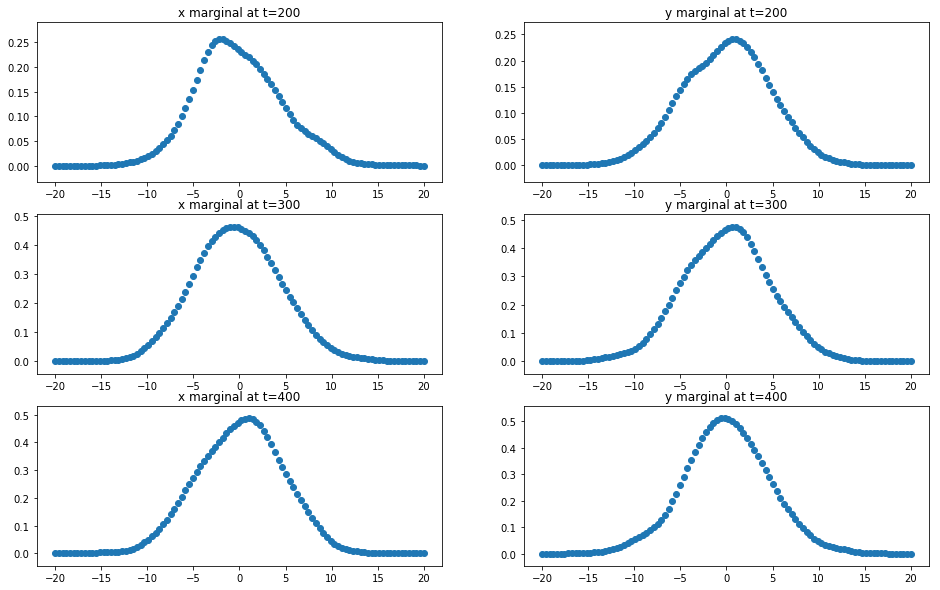

In [20]:
bkernel = lambda pt : kernel(pt) * backs.shape[-1]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))

for row, t in enumerate([200, 300, 400]):
    def y_marginal(y):
        return scipy.integrate.quad(lambda x : bkernel([t,x,y]), -30, 30)[0]
    def x_marginal(x):
        return scipy.integrate.quad(lambda y : bkernel([t,x,y]), -30, 30)[0]
    x = np.linspace(-20, 20, 100)
    xprob = [ x_marginal(xx) for xx in x ]
    ax[row][0].scatter(x, xprob)
    ax[row][0].set_title("x marginal at t={}".format(t))
    xprob = [ y_marginal(xx) for xx in x ]
    ax[row][1].scatter(x, xprob)
    ax[row][1].set_title("y marginal at t={}".format(t))

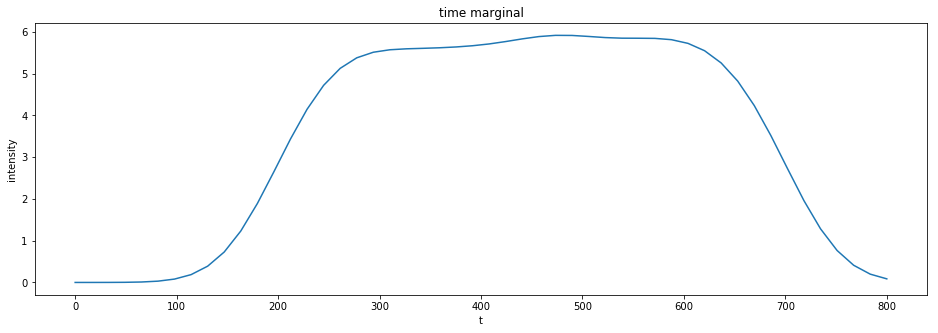

In [21]:
def tx_marginal(t, x):
    return scipy.integrate.quad(lambda y : bkernel([t,x,y]), -30, 30)[0]
def t_marginal(t):
    return scipy.integrate.quad(lambda x : tx_marginal(t, x), -30, 30)[0]

t = np.linspace(0,800,50)
tprob = [ t_marginal(tt) for tt in t ]
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(t, tprob)
ax.set_title("time marginal")
ax.set_xlabel("t")
ax.set_ylabel("intensity")
None

## Using a k=15 nearest neighbour Gaussian KDE

Let us look at what the KDE returns for the background rate.  The real distribution is Gaussian (standard deviation 4.5) in space, and constant with rate $\mu = 5.71$ in space.  We have data points in the time range about [250:500] so we expect moderately poor behaviour near the edges due to edge effects (and the fact that at this stage, we're not using a KDE which is well suited to the "factorised" nature of the background density $\nu(t) \mu(x,y)$).

The peak of the Gaussian, with one variable integrated out, should be $\mu / \sqrt{2\pi \times 4.5} \approx 0.51$.

In [22]:
def plot_real_background():
    def t_actual(t):
        return ( (t >= time_range[0]) & (t <= time_range[1]) ) * 5.71
    xy_norm = 5.71 * (time_range[1] - time_range[0])
    def xy_actual(x):
        return np.exp(-x**2/(2*4.5**2)) / (np.sqrt(2*np.pi)*4.5) * xy_norm
    
    fig, ax = plt.subplots(ncols=3, figsize=(16,5))
    t = np.linspace(time_range[0] - 100, time_range[1] + 100, 100)
    ax[0].plot(t, t_actual(t), linewidth=1, color="red")
    x = np.linspace(-20, 20, 100)
    ax[1].plot(x, xy_actual(x), linewidth=1, color="red")
    y = np.linspace(-20, 20, 100)
    ax[2].plot(y, xy_actual(y), linewidth=1, color="red")
    for i, s in enumerate(list("txy")):
        ax[i].set_title(s+" marginal")
    return ax, t, x, y

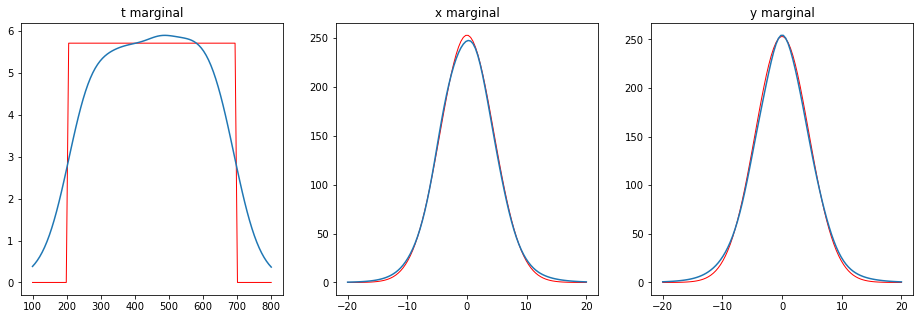

In [23]:
# Remember to renormalise by multiplying by backs.shape[-1]
t_marginal = open_cp.kernels.marginal_knng(backs, 0)
x_marginal = open_cp.kernels.marginal_knng(backs, 1)
y_marginal = open_cp.kernels.marginal_knng(backs, 2)

ax, t, x, y = plot_real_background()
ax[0].plot(t, t_marginal(t) * backs.shape[-1])
ax[1].plot(x, x_marginal(x) * backs.shape[-1])
_ = ax[2].plot(y, y_marginal(y) * backs.shape[-1])

## Estimator from Mohler et al, consider time and space separately

We try this again, but now following Mohler et al. more closely, and estimating $\nu$ and $\mu$ separately, using $k=100$ nearest neighbour distance for $\nu$ and $k=15$ nearest neighbour distance for $\mu$.

In [24]:
KDE = open_cp.kernels.KNNG1_NDFactors(100, 15)
bk = KDE(backs)
time_kernel, space_kernel = KDE.first(backs), KDE.rest(backs)

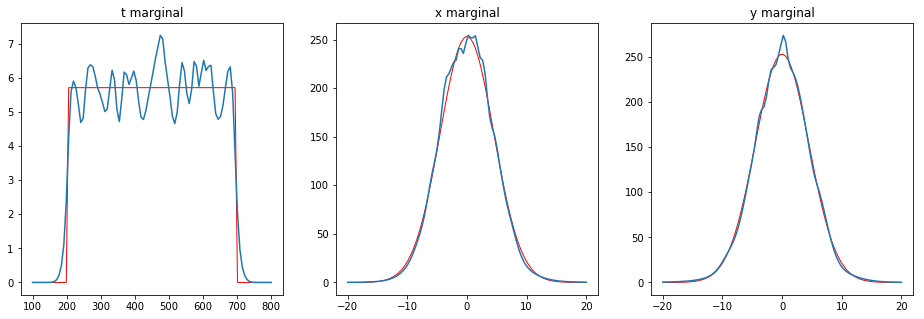

In [25]:
x_marginal = open_cp.kernels.marginal_knng(backs[1:], 0)
y_marginal = open_cp.kernels.marginal_knng(backs[1:], 1)

ax, t, x, y = plot_real_background()
ax[0].plot(t, time_kernel(t) * backs.shape[-1])
ax[1].plot(x, x_marginal(x) * backs.shape[-1])
_ = ax[2].plot(y, y_marginal(y) * backs.shape[-1])

This is very noisy, but has better edge effects, I think.

## Triggered events kernel estimation

We now look at the 3D estimated kernel for the "triggered" events.

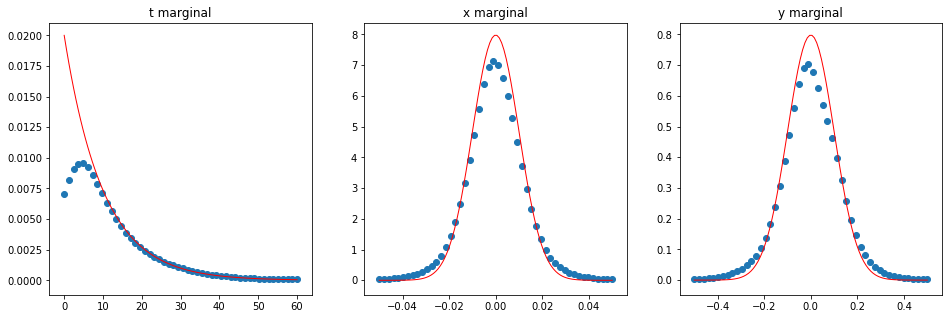

In [26]:
rescale = trigs.shape[-1] / pts.shape[-1]

def plot_marginals(trigs, time_correction=1):
    ax = plot_actual_trig_marginals()

    tc = np.linspace(0,60,50)
    ax[0].scatter(tc, open_cp.kernels.marginal_knng(trigs, 0)(tc) * rescale * time_correction)
    xc = np.linspace(-0.05,0.05,50)
    ax[1].scatter(xc, open_cp.kernels.marginal_knng(trigs, 1)(xc) * rescale)
    yc = np.linspace(-0.5,0.5,50)
    ax[2].scatter(yc, open_cp.kernels.marginal_knng(trigs, 2)(yc) * rescale)
    for i, s in enumerate(list("txy")):
        ax[i].set_title(s+" marginal")
        
plot_marginals(trigs)

These plots show a reasonably good agreement with those in Mohler, though with heavier tails.  As explored in the "kernels" notebook, the variable bandwidth KDE deployed here is actually quite poor at estimating this distribution.

In particular, the estimator makes no attempt at all to deal with the fact that the time distribution has a discontinuity at $t=0$.  As suggested by Rosser and Cheng (though this is slightly unclear in their paper) one solution is to reflect the data about $t=0$, compute the kernel estimate, and then reflect the kernel estimate about $0$ (which is equivalent to only using the kernel in the region $t\geq 0$ but doubling the intensity).  This gives a better match for the time marginal.

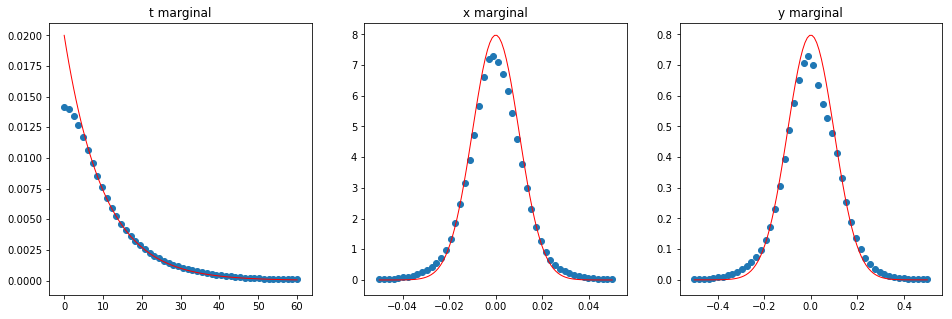

In [27]:
reflected = trigs * np.asarray([-1,1,1])[:,None]
plot_marginals(np.hstack([trigs, reflected]), 2)

# Optimising

Above, we used the real kernels $\nu,\mu$ and $g$ to construct the "p matrix" to sample from.  To fully re-create the appendix of Mohler et al, we need to provide a reasonable "guess" as to the initial kernels, so ask to form an initial "p matrix".  We follow Rosser, Cheng, we initially set $p_{ii}=1$ and
$$ p_{ij} = \exp\big( -\alpha(t_j-t_i) \big) \exp\Big( \frac{-(x_j-x_i)^2 - (y_j-y_i)^2}{2\beta^2} \Big), $$
for some parameters $\alpha>0,\beta>0$. Finally we normalise each column of $p$ to sum to $1$.

To start the optimisation, we need to provide reasonable "bandwidths" for the data.  The `StocasticDecluster` class comes with parameters suitable for real data, so we need to override them.

In [28]:
decluster = sepp.StocasticDecluster()
decluster.points = pts
decluster.background_kernel_estimator = open_cp.kernels.KNNG1_NDFactors(100, 15)
decluster.trigger_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE(15)
decluster.initial_time_bandwidth = 10
decluster.initial_space_bandwidth = 0.1
decluster.space_cutoff = 1.0
decluster.time_cutoff = 150

We take a sample of the initial p matrix, just to check that the parameters are sane.

In [29]:
p = sepp.initial_p_matrix(pts, initial_time_bandwidth = decluster.initial_time_bandwidth,
                          initial_space_bandwidth = decluster.initial_space_bandwidth)
backs, trigs = sepp.sample_points(pts, p)
backs.shape, trigs.shape

((3, 3344), (3, 209))

In [30]:
result = decluster.run_optimisation(iterations=75)

Here we plot the $L^2$ norm $\|P_n - P_{n-1}\|^2$, which we define as the square-root of the sum of squares of each entry of the matrix.  This does not show quite the same convergence properties as in Mohler et al, where they rapidly get down to errors of the order $10^{-7}$ with a slightly largest data set.

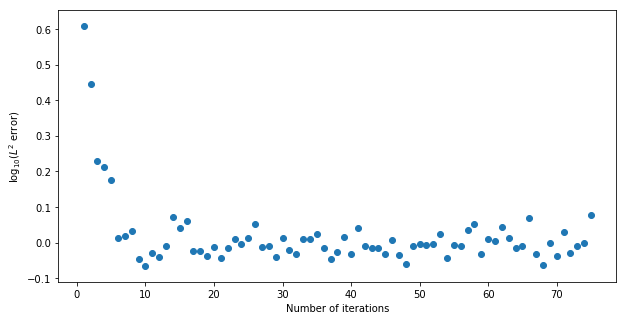

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
length = len(result.ell2_error)
ax.scatter(np.arange(1,length + 1), np.log10(np.sqrt(result.ell2_error)))
ax.set_xlabel("Number of iterations")
ax.set_xticks(np.arange(0,length + 1,10))
ax.set_ylabel("$\log_{10}(L^2$ error$)$")
None

We'll take a sampling of points to allow us to quickly compute marginals and compare the estimated kernels against the acutal kernels.

In [32]:
backs, trigs = sepp.sample_points(decluster.points, result.p)

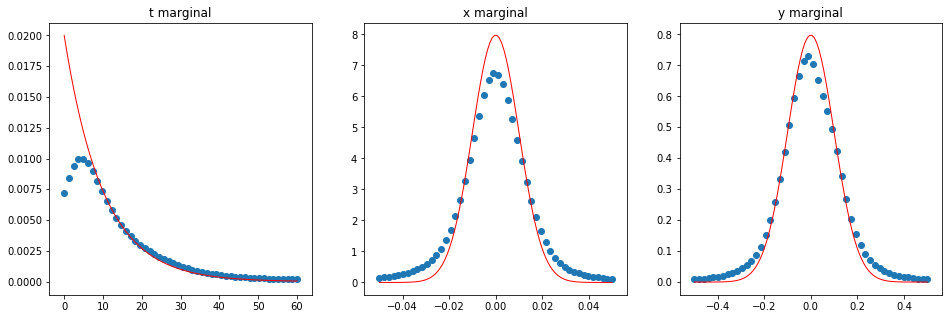

In [33]:
rescale = trigs.shape[-1] / pts.shape[-1]
plot_marginals(trigs)

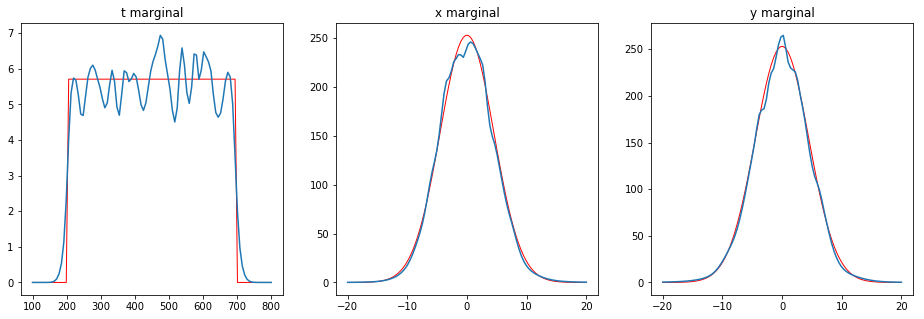

In [34]:
time_kernel = decluster.background_kernel_estimator.first(backs)
x_marginal = open_cp.kernels.marginal_knng(backs[1:], 0)
y_marginal = open_cp.kernels.marginal_knng(backs[1:], 1)

ax, t, x, y = plot_real_background()
ax[0].plot(t, time_kernel(t) * backs.shape[-1])
ax[1].plot(x, x_marginal(x) * backs.shape[-1])
_ = ax[2].plot(y, y_marginal(y) * backs.shape[-1])